In [1]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

## 数据读取

In [2]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root="../data",train=True,transform=trans,download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="../data",train=False,transform=trans,download=True)

In [3]:
mnist_train[0][1]

9

array([<Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'dress'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'pullover'}>,
       <Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'pullover'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 'trouser'}>,
       <Axes: title={'center': 't-shirt'}>], dtype=object)

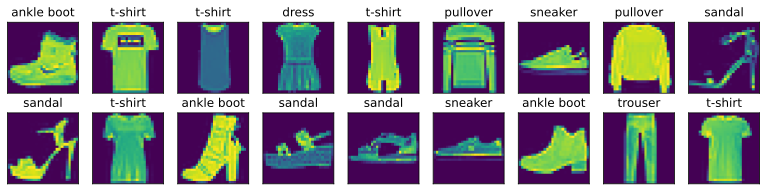

In [4]:
X,y = next(iter(data.DataLoader(mnist_train,batch_size=18)))
d2l.show_images(X.reshape((18,28,28)),2,9,titles=d2l.get_fashion_mnist_labels(y))

In [5]:
batch_size = 256

train_iter = data.DataLoader(mnist_train,batch_size,shuffle=True,num_workers=4)
test_iter = data.DataLoader(mnist_test,batch_size,shuffle=False,num_workers=4)

## softmax网络实现

In [6]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1,keepdim=True)
    return X_exp / partition

In [7]:
def net(X,w,b):
    return softmax(torch.matmul(X,w) +b)

In [8]:
#Loss: Cross Entropy
def cross_entropy(y_hat,y):
    return - torch.log(y_hat[range(len(y_hat)),y])

In [9]:
def sgd(params,lr,batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## 训练模型

In [10]:
epochs = 5
loss = cross_entropy
optim = sgd
input = 28 * 28
output = 10
lr = 0.03

w = torch.normal(0,0.01,size=(input,output),requires_grad=True)
b = torch.zeros(1,requires_grad=True)

for epoch in range(epochs):
    for X,y in train_iter:
        l = loss(net(X.reshape(-1,28*28),w,b),y)
        l.sum().backward()
        sgd([w,b],lr,batch_size)
    with torch.no_grad():
        test_X,test_y = next(iter(test_iter))
        #print(f"epoch{epoch+1}    test_loss {loss(net(test_X.reshape(-1,28*28),w,b),test_y).sum()/batch_size}")
        print(f"epoch{epoch+1}    test_acc {d2l.evaluate_accuracy_gpu(lambda X:net(X.reshape(-1,28*28),w,b),iter(test_iter))}")

epoch1    test_acc 0.738
epoch2    test_acc 0.7699
epoch3    test_acc 0.7847
epoch4    test_acc 0.7953
epoch5    test_acc 0.8011


In [11]:
for X,y in test_iter:
    break
net(X.reshape(-1,28*28),w,b)[0]

tensor([1.4833e-04, 1.5252e-04, 7.6919e-04, 3.2599e-04, 1.6375e-03, 1.7066e-01,
        5.8856e-04, 2.3543e-01, 2.8435e-02, 5.6185e-01],
       grad_fn=<SelectBackward0>)

array([<Axes: title={'center': 'ankle boot\nankle boot'}>,
       <Axes: title={'center': 'pullover\npullover'}>,
       <Axes: title={'center': 'trouser\ntrouser'}>,
       <Axes: title={'center': 'trouser\ntrouser'}>,
       <Axes: title={'center': 'shirt\nshirt'}>,
       <Axes: title={'center': 'trouser\ntrouser'}>], dtype=object)

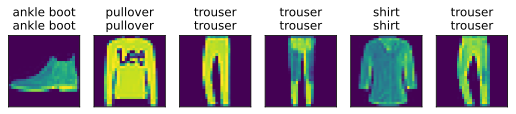

In [12]:
n = 6
preds = d2l.get_fashion_mnist_labels(net(X.reshape(-1,28*28),w,b).argmax(1))
trues = d2l.get_fashion_mnist_labels(y)
titles = [pred + "\n" + true for pred,true in zip(preds,trues)]
images = X[0:6].reshape((n,28,28))
d2l.show_images(images,1,n,titles=titles)

## 运用 torch.nn 的简洁实现

In [13]:
import torch.nn as nn
from torch.optim import SGD

In [14]:
net = nn.Sequential(nn.Flatten(),nn.Linear(28*28,10),nn.Softmax(dim=1))
loss = nn.CrossEntropyLoss()
optim = SGD(net.parameters(),lr=0.05)

def init_params(layer):
    if type(layer) == nn.Linear:
        nn.init.normal_(layer.weight,std=0.01)

net.apply(init_params)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
  (2): Softmax(dim=1)
)

In [15]:
train_iter = data.DataLoader(mnist_train,batch_size,shuffle=True,num_workers=4)
test_iter = data.DataLoader(mnist_test,batch_size,shuffle=False,num_workers=4)

In [16]:
epochs = 5

for epoch in range(epochs):
    for X,y in train_iter:
        l = loss(net(X),y)
        net.zero_grad()
        l.backward()
        optim.step()
    with torch.no_grad():
        print(f"epoch{epoch+1}    test_acc {d2l.evaluate_accuracy_gpu(net,iter(test_iter))}")        

epoch1    test_acc 0.6206
epoch2    test_acc 0.626
epoch3    test_acc 0.6277
epoch4    test_acc 0.6863
epoch5    test_acc 0.7256


array([<Axes: title={'center': 'trouser\ntrouser'}>,
       <Axes: title={'center': 'sneaker\nsandal'}>,
       <Axes: title={'center': 'coat\ncoat'}>,
       <Axes: title={'center': 'ankle boot\nankle boot'}>,
       <Axes: title={'center': 'dress\ndress'}>,
       <Axes: title={'center': 'coat\ncoat'}>], dtype=object)

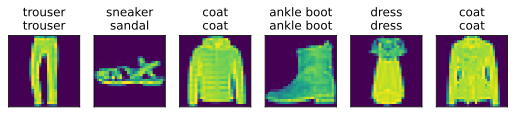

In [17]:
n = 6
preds = d2l.get_fashion_mnist_labels(net(X).argmax(1))
trues = d2l.get_fashion_mnist_labels(y)
titles = [pred + "\n" + true for pred,true in zip(preds,trues)]
images = X[0:6].reshape((n,28,28))
d2l.show_images(images,1,n,titles=titles)